In [1]:
# Cell 1: Import libraries and configure environment
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN optimizations
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # Suppress TensorFlow warnings

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import warnings

# Check for keras-tcn availability
try:
    from tcn import TCN
    tcn_available = True
except ImportError:
    warnings.warn("keras-tcn not installed. Skipping TCN model. Install with: pip install keras-tcn")
    tcn_available = False

# Set random seed for reproducibility
np.random.seed(42)

/Users/macbook/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
url = "https://raw.githubusercontent.com/mkumakech/Covid-19_Pandemic/refs/heads/master/kano%20(1).csv"
df = pd.read_csv(url)

In [3]:
#data.to_csv("kano.csv", index=False)

In [4]:
df.head()

,State,Confirmed,Discharged,Death,Date
0,Kano,92,0,0,01/05/2020
1,Kano,2,7,3,02/05/2020
2,Kano,29,0,0,03/05/2020
3,Kano,23,0,2,04/05/2020
4,Kano,32,3,3,05/05/2020


In [5]:
df.columns

Index(['State', 'Confirmed', 'Discharged', 'Death', 'Date'], dtype='object')

In [6]:
# Assume columns: 'Date', 'Confirmed', 'Discharged', 'Deaths'
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
# data = data.sort_values('Date')
# data = data.set_index('Date')

In [7]:
df.columns

Index(['State', 'Confirmed', 'Discharged', 'Death', 'Date'], dtype='object')

In [8]:
# Verify required columns
required_columns = ['Date', 'Confirmed', 'Discharged', 'Death']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"Missing required columns: {missing_columns}")

In [9]:
# Cell 2: Load and preprocess the dataset
# Preprocess the dataset

try:
    if df['Date'].isna().any():
        print("Warning: Some dates could not be parsed. Invalid dates:", df[df['Date'].isna()])
        data = df.dropna(subset=['Date'])
except Exception as e:
    print(f"Error parsing dates: {str(e)}")
    raise

# data = data.sort_values('Date')
# data = data.set_index('Date')

In [12]:
# Check for missing values and fill if any
df.isna().sum()

State         0
Confirmed     0
Discharged    0
Death         0
Date          0
dtype: int64

In [13]:
# Select relevant columns
data = df[['Confirmed', 'Discharged', 'Death']]


#data = data.fillna(method='ffill')
data = data.interpolate()


In [14]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

In [15]:
# Function to create sequences
def create_sequences(data, seq_length, target_col_idx):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_col_idx])
    return np.array(X), np.array(y)


In [16]:
# Parameters
seq_length = 7  # Use 7 days to predict the next day
targets = ['Confirmed', 'Discharged', 'Death']
target_indices = {'Confirmed': 0, 'Discharged': 1, 'Death': 2}
X_dict, y_dict = {}, {}

In [17]:
# Create sequences for each target
for target in targets:
    X, y = create_sequences(scaled_data, seq_length, target_indices[target])
    X_dict[target], y_dict[target] = X, y

In [18]:
# Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(X_dict['Confirmed']))
X_train_dict, X_test_dict, y_train_dict, y_test_dict = {}, {}, {}, {}
for target in targets:
    X_train_dict[target] = X_dict[target][:train_size]
    X_test_dict[target] = X_dict[target][train_size:]
    y_train_dict[target] = y_dict[target][:train_size]
    y_test_dict[target] = y_dict[target][train_size:]

# Display dataset info
print("Dataset shape:", data.shape)
print("Training samples:", train_size)
print("Test samples:", len(X_dict['Confirmed']) - train_size)

Dataset shape: (365, 3)
Training samples: 286
Test samples: 72


# Step 2: Model Implementation

### LSTM Model

In [19]:
def build_lstm_model(seq_length, n_features):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, n_features), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

### GRU Model

In [20]:
def build_gru_model(seq_length, n_features):
    model = Sequential([
        GRU(50, activation='relu', input_shape=(seq_length, n_features), return_sequences=True),
        GRU(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

### CNN Model

In [21]:
def build_cnn_model(seq_length, n_features):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, n_features)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

### TCN Model

In [22]:
from tcn import TCN

def build_tcn_model(seq_length, n_features):
    model = Sequential([
        TCN(input_shape=(seq_length, n_features), nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8]),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Step 3: Training and Prediction

In [23]:
# models = {
#     'LSTM': build_lstm_model,
#     'GRU': build_gru_model,
#     'CNN': build_cnn_model,
#     'TCN': build_tcn_model
# }

# predictions = {target: {model_name: None for model_name in models} for target in targets}
# metrics = {target: {model_name: {'RMSE': None, 'MAE': None} for model_name in models} for target in targets}

# for target in targets:
#     for model_name, model_fn in models.items():
#         model = model_fn(seq_length, X_dict[target].shape[2])
#         model.fit(X_train_dict[target], y_train_dict[target], epochs=50, batch_size=32, verbose=0)
        
#         # Predict
#         y_pred = model.predict(X_test_dict[target], verbose=0)
#         predictions[target][model_name] = y_pred
        
#         # Calculate metrics
#         rmse = np.sqrt(mean_squared_error(y_test_dict[target], y_pred))
#         mae = mean_absolute_error(y_test_dict[target], y_pred)
#         metrics[target][model_name]['RMSE'] = rmse
#         metrics[target][model_name]['MAE'] = mae

In [24]:
# Cell 4: Train models and generate predictions
models = {
    'LSTM': build_lstm_model,
    'GRU': build_gru_model,
    'CNN': build_cnn_model,
    'TCN': build_tcn_model
}
if tcn_available:
    models['TCN'] = build_tcn_model

print("Models available:", list(models.keys()))

predictions = {target: {model_name: None for model_name in models} for target in targets}
metrics = {target: {model_name: {'RMSE': None, 'MAE': None} for model_name in models} for target in targets}

for target in targets:
    for model_name, model_fn in models.items():
        print(f"Training {model_name} for {target}...")
        try:
            model = model_fn(seq_length, X_dict[target].shape[2])
            model.fit(X_train_dict[target], y_train_dict[target], epochs=50, batch_size=32, verbose=0)
            
            # Predict
            y_pred = model.predict(X_test_dict[target], verbose=0)
            predictions[target][model_name] = y_pred.flatten()
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_test_dict[target], y_pred))
            mae = mean_absolute_error(y_test_dict[target], y_pred)
            metrics[target][model_name]['RMSE'] = rmse
            metrics[target][model_name]['MAE'] = mae
        except Exception as e:
            print(f"Error training {model_name} for {target}: {str(e)}")
            predictions[target][model_name] = np.zeros_like(y_test_dict[target])
            metrics[target][model_name]['RMSE'] = float('inf')
            metrics[target][model_name]['MAE'] = float('inf')

Models available: ['LSTM', 'GRU', 'CNN', 'TCN']
Training LSTM for Confirmed...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU for Confirmed...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training CNN for Confirmed...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training TCN for Confirmed...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Training LSTM for Discharged...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU for Discharged...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training CNN for Discharged...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training TCN for Discharged...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Training LSTM for Death...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU for Death...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training CNN for Death...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training TCN for Death...


/Users/macbook/Library/Python/3.9/lib/python/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


###  Graphical Representations

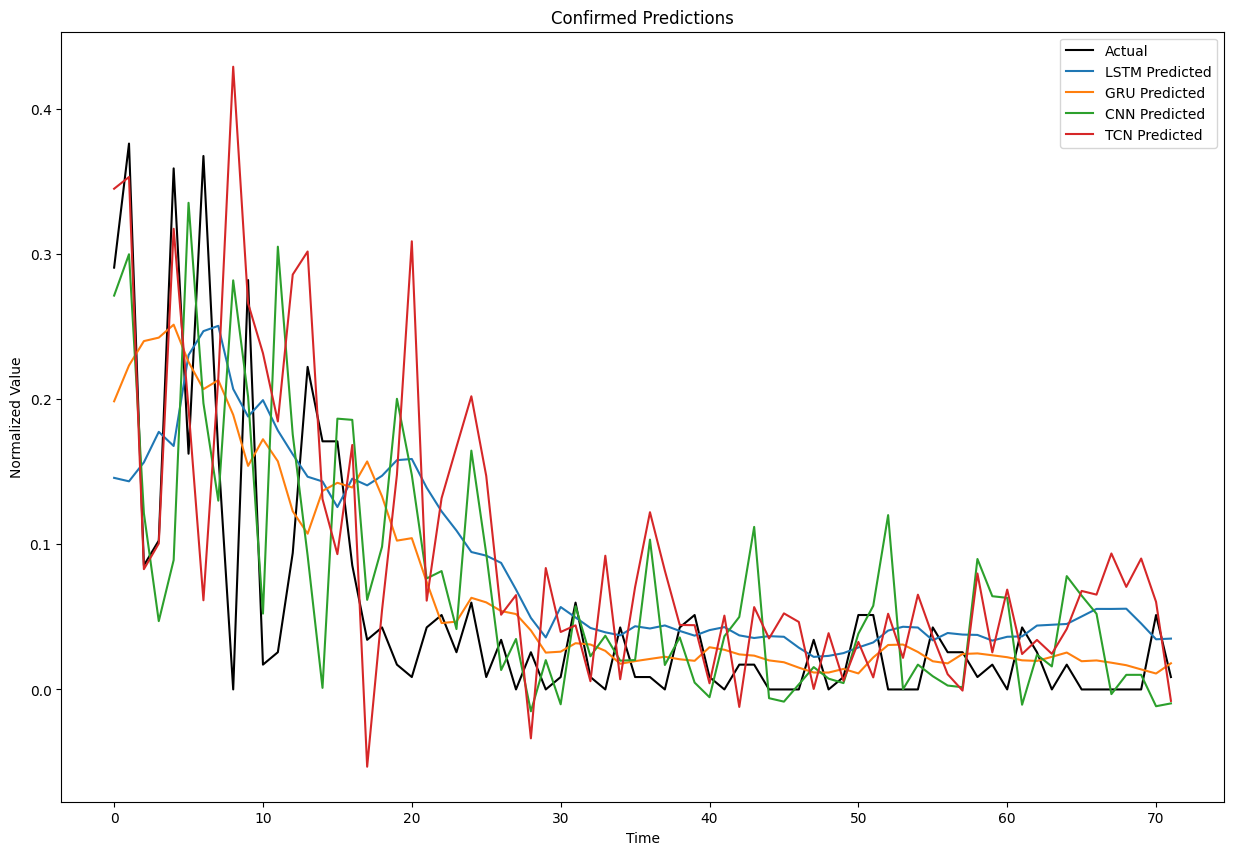

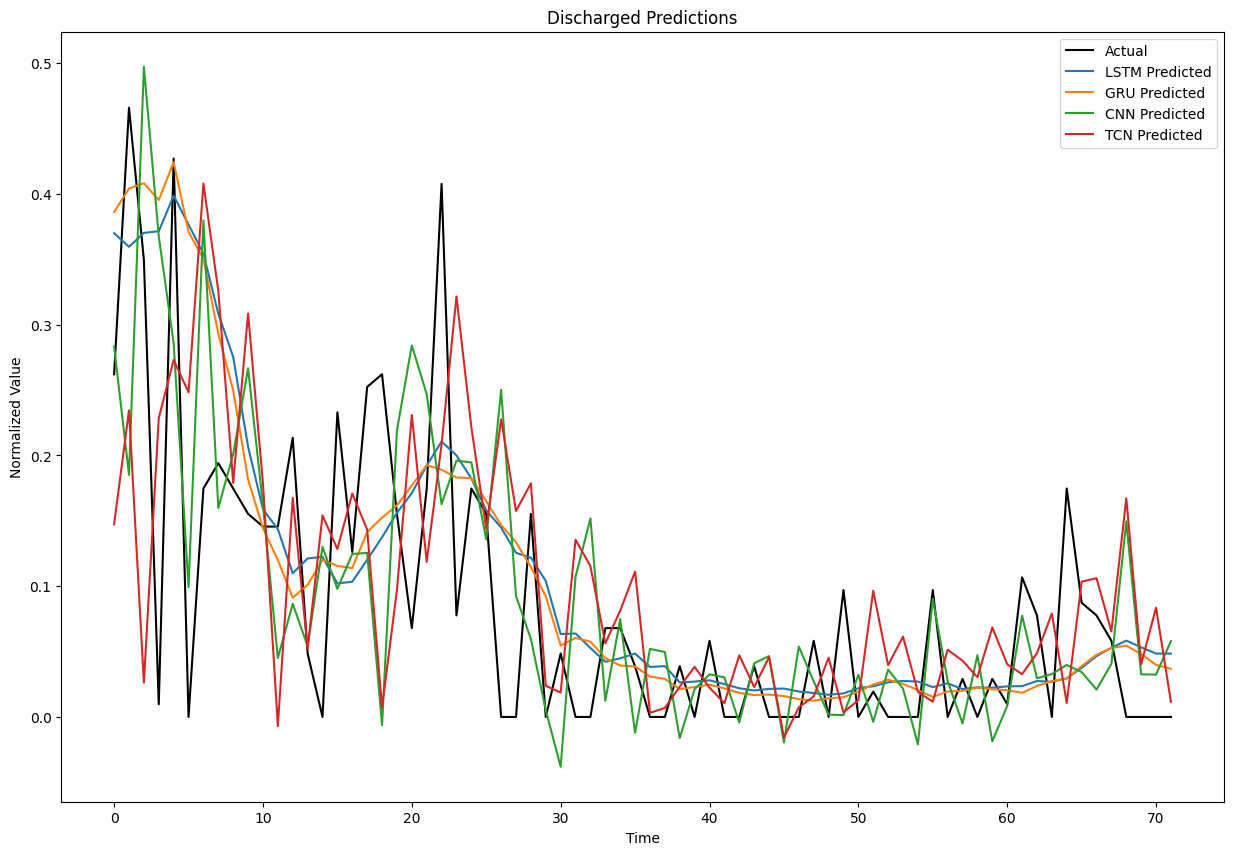

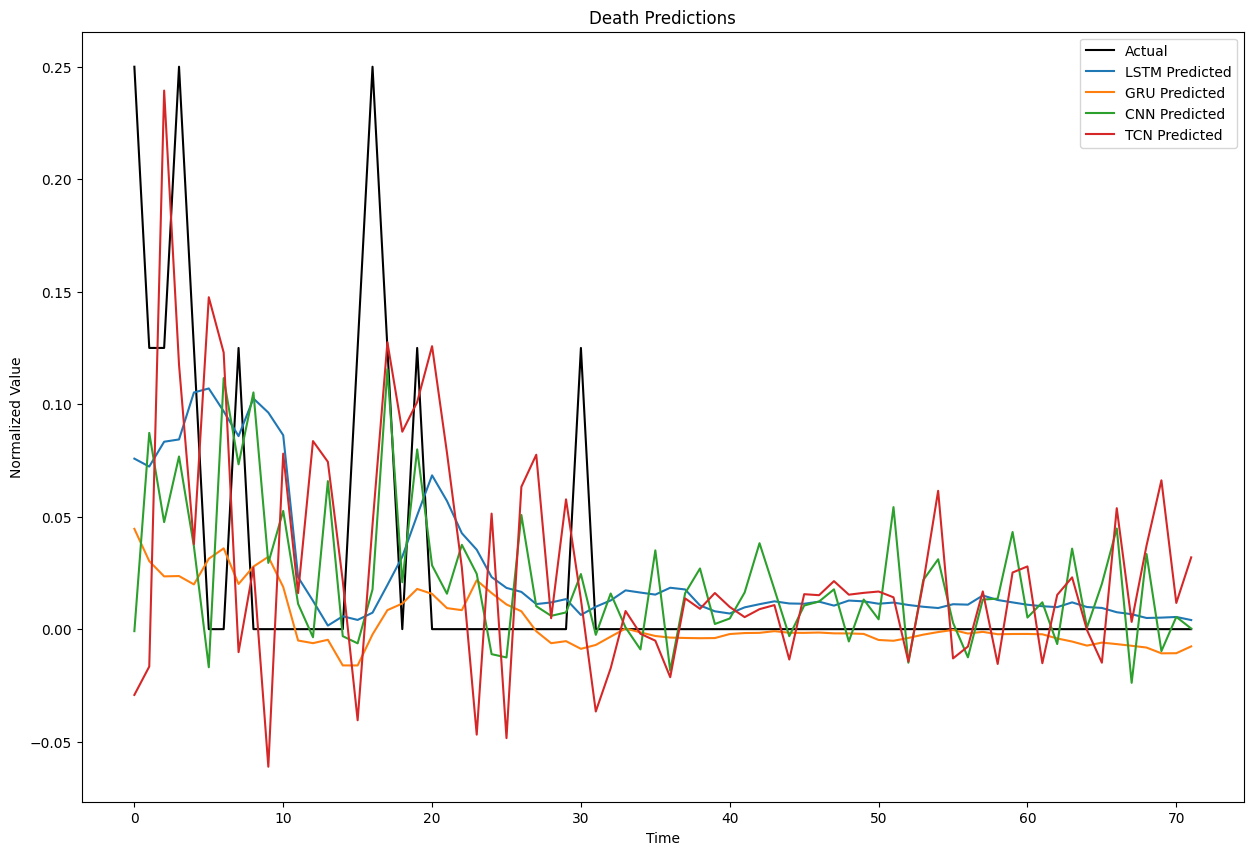

In [25]:
for target in targets:
    plt.figure(figsize=(15, 10))
    plt.plot(y_test_dict[target], label='Actual', color='black')
    for model_name in models:
        plt.plot(predictions[target][model_name], label=f'{model_name} Predicted')
    plt.title(f'{target} Predictions')
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.show()

###  Evaluation Metrics

In [26]:
for target in targets:
    print(f"\nEvaluation Metrics for {target}:")
    for model_name in models:
        print(f"{model_name} - RMSE: {metrics[target][model_name]['RMSE']:.4f}, MAE: {metrics[target][model_name]['MAE']:.4f}")


Evaluation Metrics for Confirmed:
LSTM - RMSE: 0.0766, MAE: 0.0580
GRU - RMSE: 0.0644, MAE: 0.0446
CNN - RMSE: 0.0855, MAE: 0.0566
TCN - RMSE: 0.0996, MAE: 0.0659

Evaluation Metrics for Discharged:
LSTM - RMSE: 0.0935, MAE: 0.0624
GRU - RMSE: 0.0932, MAE: 0.0602
CNN - RMSE: 0.1065, MAE: 0.0754
TCN - RMSE: 0.1127, MAE: 0.0818

Evaluation Metrics for Death:
LSTM - RMSE: 0.0573, MAE: 0.0342
GRU - RMSE: 0.0611, MAE: 0.0282
CNN - RMSE: 0.0591, MAE: 0.0347
TCN - RMSE: 0.0718, MAE: 0.0481


###  Bar Chart for Metrics

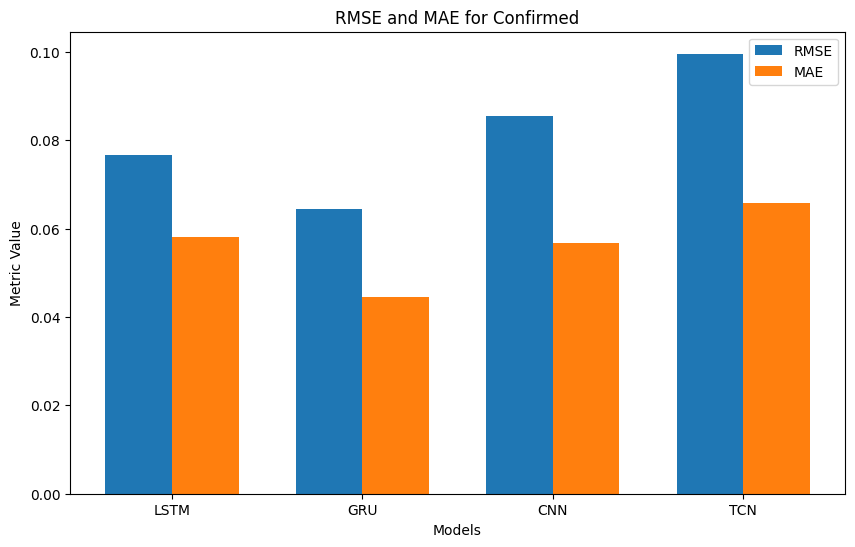

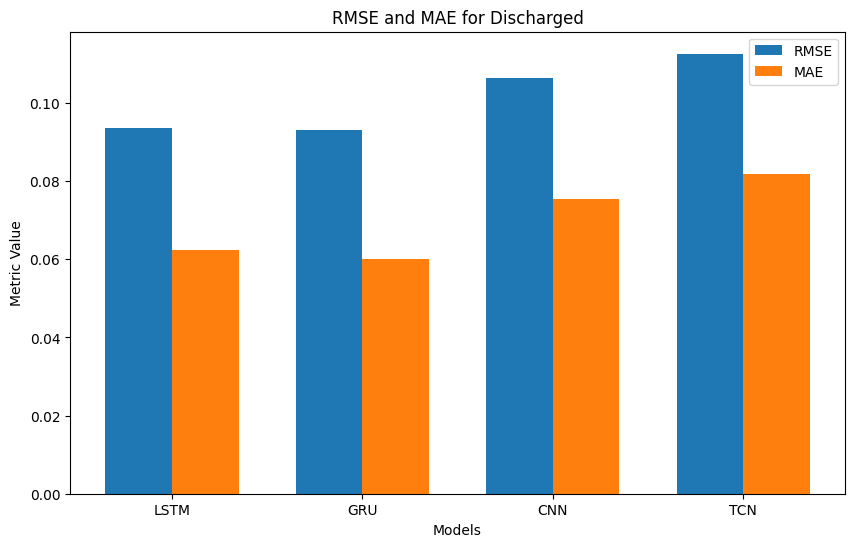

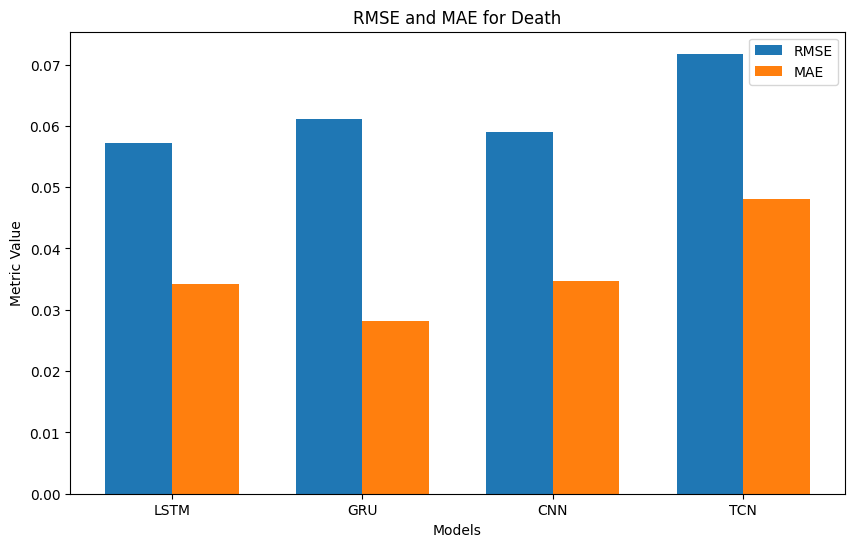

In [27]:
for target in targets:
    rmse_values = [metrics[target][model_name]['RMSE'] for model_name in models]
    mae_values = [metrics[target][model_name]['MAE'] for model_name in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, rmse_values, width, label='RMSE')
    ax.bar(x + width/2, mae_values, width, label='MAE')
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'RMSE and MAE for {target}')
    ax.set_xticks(x)
    ax.set_xticklabels(models.keys())
    ax.legend()
    plt.show()

##  Best Performing Model

In [28]:
best_models = {}
for target in targets:
    rmse_values = {model_name: metrics[target][model_name]['RMSE'] for model_name in models}
    best_model = min(rmse_values, key=rmse_values.get)
    best_models[target] = best_model
    print(f"Best model for {target}: {best_model} (RMSE: {rmse_values[best_model]:.4f})")

Best model for Confirmed: GRU (RMSE: 0.0644)
Best model for Discharged: GRU (RMSE: 0.0932)
Best model for Death: LSTM (RMSE: 0.0573)


RMSE penalizes larger errors more heavily, making it sensitive to outliers.
MAE provides a linear measure of error, useful for understanding average error magnitude.
The best model may vary by target variable (e.g., LSTM might perform best for Deaths, while TCN excels for Confirmed Cases).
TCN often outperforms others in time series tasks due to its ability to capture long-term dependencies with dilated convolutions, but LSTM and GRU are robust for sequential data with strong temporal patterns. CNN may perform well if local patterns are significant but may struggle with long-term dependencies.